In [1]:
import pandas as pd
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import statsmodels.api as sm
from statsmodels.iolib.summary2 import summary_col

from shapely import wkt


from utils import make_precinct_counts,make_demo_map,job_cols,race_cols,cols_to_keep,scale_and_cluster,make_edname,map_round_votes

In [10]:
demo_cluster = pd.read_csv('../../chapter_two/data/occupation_demo_clusters_on_ed.csv')
d23 = pd.read_csv('../../cc_election_cleaning/all_rounds_results/district_23.csv')
ed_level = pd.read_csv('../../cc_election_cleaning/occupation_demo_data_feb21.csv')

ed_shapefile = '../../chapter_two/data/nyed_21a/nyed.shp'
ed_gdf = gpd.read_file(ed_shapefile)

full_results = pd.read_csv('../../cc_election_cleaning/election_results_with_vote_sponsor_cluster_FEB13.csv')

full_results_twenty_three = full_results[full_results['district'] == 23]
winner_twenty_three = full_results_twenty_three[full_results_twenty_three['winner'] == True]
occ_df = pd.read_csv('../../cc_election_cleaning/occupation_election_feb21.csv')
eds_23 = full_results_twenty_three['ed_name'].unique().tolist()

In [3]:
full_results_twenty_three.groupby('candidate')['vote'].sum().sort_values(ascending=False)

candidate
Linda Lee               4923.0
Jaslin Kaur             3999.0
Steve Behar             2171.0
Debra Markell           2067.0
Sanjeev Kumar Jindal    1766.0
James F. Reilly         1012.0
Koshy O. Thomas          785.0
Harpreet S. Toor         686.0
Alex Amoroso             451.0
Write-in                 117.0
overvote                  79.0
219548.0                  15.0
218105.0                   7.0
221205.0                   3.0
218121.0                   2.0
221327.0                   2.0
219510.0                   2.0
218192.0                   1.0
Name: vote, dtype: float64

In [6]:
top_three = full_results_twenty_three[full_results_twenty_three['candidate'].isin(['Linda Lee','Jaslin Kaur','Steve Behar'])]
winners = top_three.loc[top_three.groupby('ed_name')['vote_share'].idxmax()].copy()
winners['norm'] = winners.groupby('candidate')['vote_share'].transform(
    lambda x: (x - x.min()) / (x.max() - x.min())
)


In [7]:
winners['candidate'].value_counts()

candidate
Jaslin Kaur    52
Linda Lee      51
Steve Behar     6
Name: count, dtype: int64

In [8]:
def assign_color(row):
    if row['candidate'] == 'Linda Lee':
        return mpl.cm.Blues(row['norm'])
    elif row['candidate'] =='Jaslin Kaur':
        return mpl.cm.Reds(row['norm'])
    else:
        return mpl.cm.Greens(row['norm'])
    
winners['color'] = winners.apply(assign_color, axis=1)

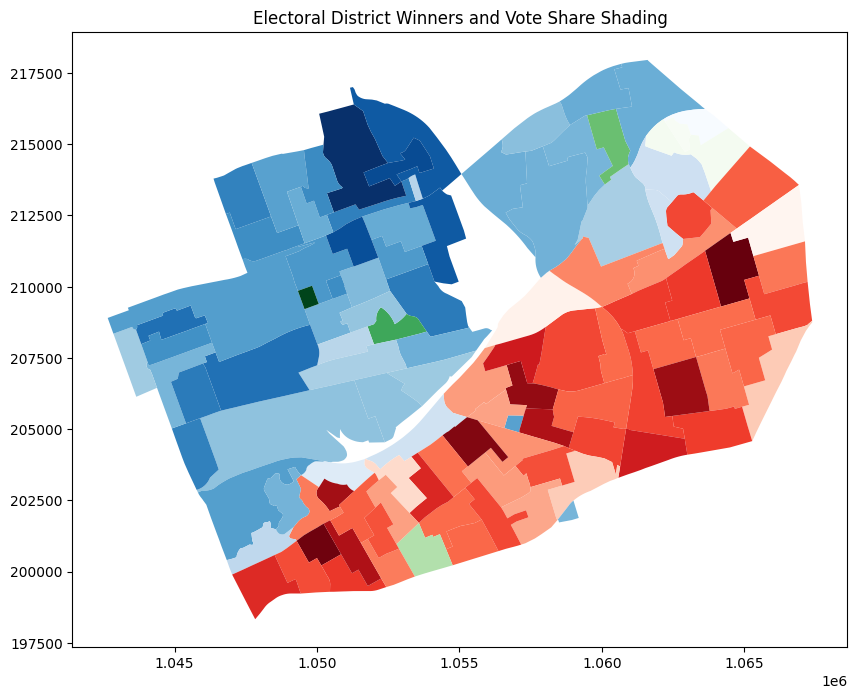

In [9]:
winners = gpd.GeoDataFrame(winners,geometry=winners['geometry'].apply(wkt.loads))

fig, ax = plt.subplots(1, figsize=(10, 10))
winners.plot(color=winners['color'], ax=ax)
ax.set_title("Electoral District Winners and Vote Share Shading")
plt.show()

In [11]:
winner_twenty_three_map = gpd.GeoDataFrame(winner_twenty_three,geometry=winner_twenty_three['geometry'].apply(wkt.loads))

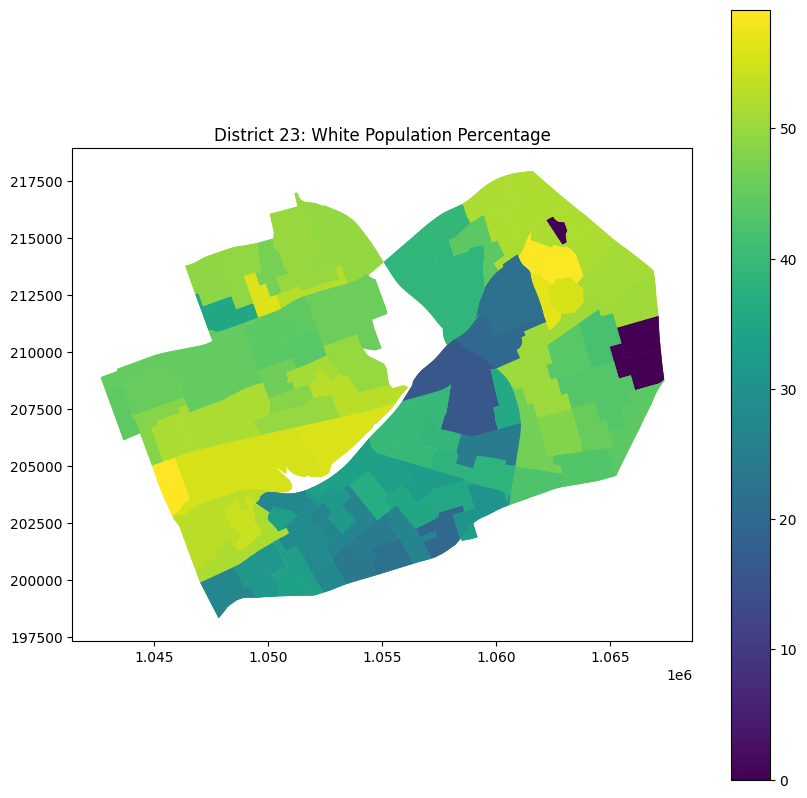

In [18]:
winner_twenty_three_map.plot(column='cvap21bapp',legend=True,figsize=(10,10),cmap='viridis')
plt.title('District 23: White Population Percentage')
plt.show()

In [23]:
winners.groupby('candidate')['nha21p'].mean()

candidate
Jaslin Kaur    37.841419
Linda Lee      43.760518
Steve Behar    35.993795
Name: nha21p, dtype: float64